In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets

# hide warnings
import warnings
warnings.simplefilter("ignore")

try:
    import chart_studio.plotly as py
except:
    !pip install chart_studio
    import chart_studio.plotly as py

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go 
init_notebook_mode(connected=True)

try:
    import seaborn as sns
except:
    !pip install --user seaborn
    import seaborn as sns

In [2]:
df = pd.read_csv("Desktop/Major/GlobalLandTemperaturesByCity.csv")

df['dt'] = pd.to_datetime(df['dt'])

df.index = df['dt']
del df['dt']

df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)
df["City"] = df["City"] + ", " + df["Country"]
df = df.drop("Country", 1)

df = df.dropna()

cities = set(df.City)

In [3]:
def check_stationarity(city_df):
    city_df.plot(figsize=(10, 10))
    
    city_df.hist(figsize=(10, 10))
    plt.show()
    
    X = city_df["AverageTemperature"].values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
    if (abs(mean1-mean2) <= 10 and abs(var1-var2) <= 10):
        print("Time Series may be Stationary, since means and variances vary only slightly.\n")
    else:
        print("Time Series may NOT be Stationary, since means and variances vary significantly.\n")
        
    print("Performing Augmented Dickey-Fuller Test to confirm stationarity...")
    
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    p = result[1]
    if (p > 0.05):
        print("Time Series is NOT Stationary, since p-value > 0.05")
        city_df = city_df.diff()  
        return False
    else:
        print("Time Series is Stationary, since p-value <= 0.05")
        return True

In [4]:
city_drop_down_menu = widgets.Dropdown(
    options=sorted(list(cities)),
    value='New York, United States',
    description='City:',
    disabled=False,
)

city_drop_down_menu


Dropdown(description='City:', index=2117, options=('A Coruña, Spain', 'Aachen, Germany', 'Aalborg, Denmark', '…

In [5]:
chosen_city = city_drop_down_menu.value
city_df = df[df.City == chosen_city].drop("City", 1)

Stationarity Check for New York, United States


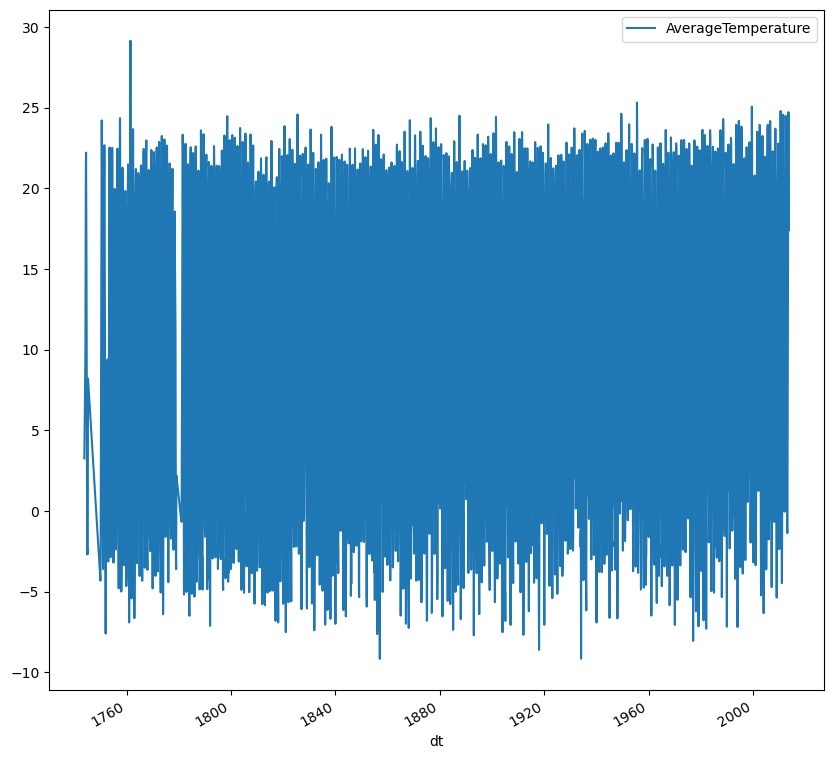

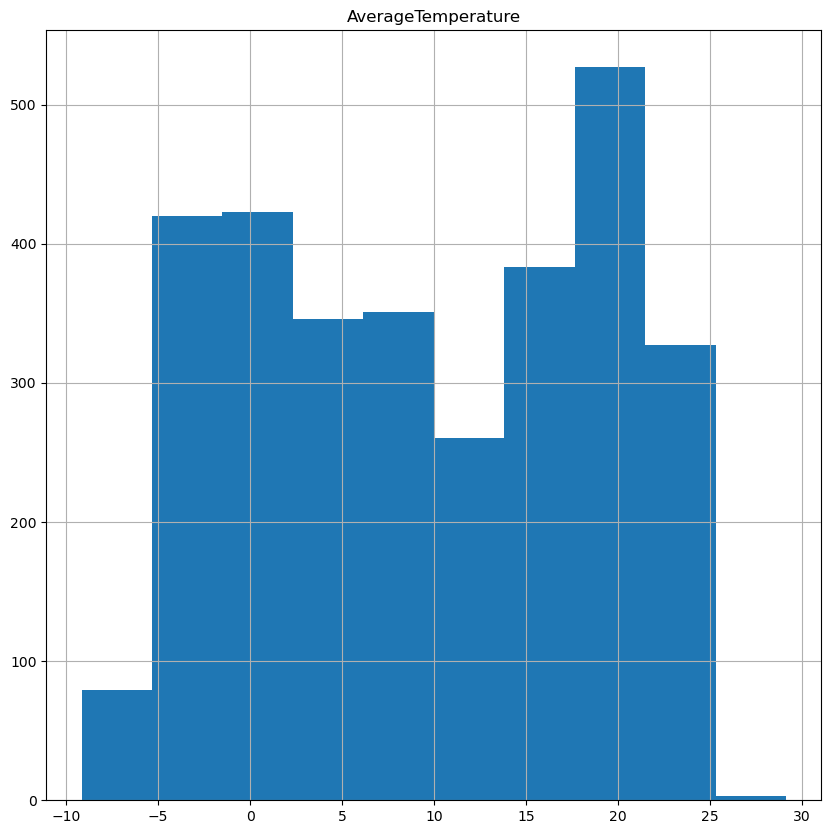

mean1=9.117772, mean2=9.928560
variance1=86.640935, variance2=84.126356
Time Series may be Stationary, since means and variances vary only slightly.

Performing Augmented Dickey-Fuller Test to confirm stationarity...
ADF Statistic: -5.157735
p-value: 0.000011
Time Series is Stationary, since p-value <= 0.05


In [6]:
print ("Stationarity Check for %s" % chosen_city)
is_stationary = check_stationarity(city_df)

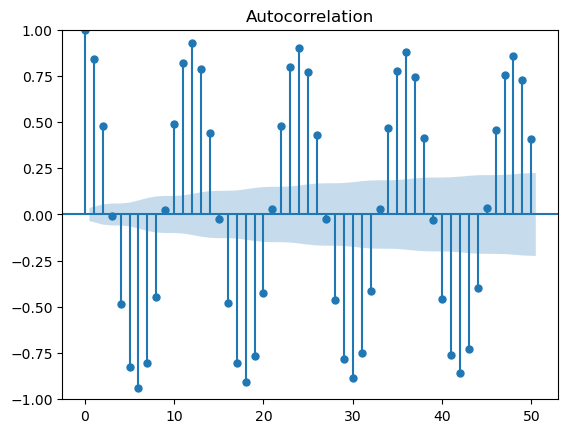

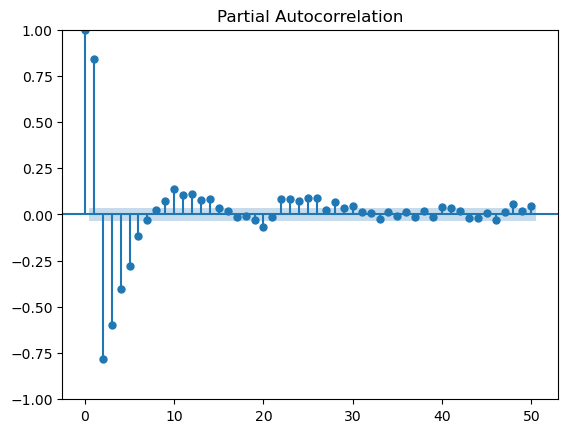

In [7]:
plot_acf(city_df,lags = 50)
plot_pacf(city_df,lags = 50)
plt.show()


if (is_stationary==True):
    d = 0
else:
    d = 1

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA



p_range = q_range = list(range(0, 3))  
aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
        
            model = ARIMA(city_df, order=(p, 1, q))  
            results = model.fit()
            
        
            aic_values.append(results.aic)
            bic_values.append(results.bic)
            pq_values.append((p, q))
            
        except Exception as e:
    
            print(f"Model fitting failed for p={p}, q={q}. Error: {e}")
            continue


if aic_values:
    best_pq_aic = pq_values[aic_values.index(min(aic_values))]
    print("(p, q) corresponding to lowest AIC score: ", best_pq_aic)

    
    best_pq_bic = pq_values[bic_values.index(min(bic_values))]
    print("(p, q) corresponding to lowest BIC score: ", best_pq_bic)
else:
    print("No valid models could be fit.")

(p, q) corresponding to lowest AIC score:  (2, 2)
(p, q) corresponding to lowest BIC score:  (2, 2)


In [9]:
from sklearn.metrics import mean_absolute_error

arima_model = ARIMA(city_df, order=(best_pq_aic[0], 0, best_pq_aic[1])).fit()
predictions = arima_model.predict(start=0, end=len(city_df)-1)

mse = mean_squared_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Squared Error:", mse)

mae = mean_absolute_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Absolute Error:", mae)

Mean Squared Error: 4.678029980505771
Mean Absolute Error: 1.5779962524056026


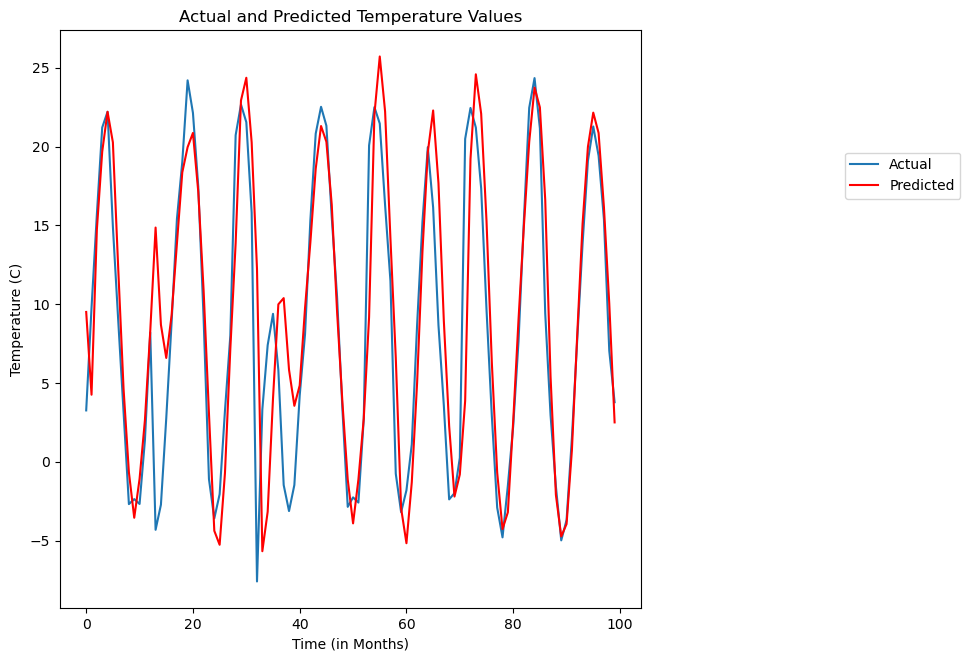

In [10]:
plt.figure(figsize=(7.5,7.5))
plt.plot(list(city_df.AverageTemperature)[:100], label="Actual")
plt.plot(list(predictions)[:100], 'r', label="Predicted")

plt.xlabel("Time (in Months)")
plt.ylabel("Temperature (C)")
plt.title("Actual and Predicted Temperature Values")

plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8))
plt.show()

In [11]:
years_drop_down_menu = widgets.Dropdown(
    options=list(range(1,201)),
    value=10,
    description='No. of Years:',
    disabled=False,
)

years_drop_down_menu

Dropdown(description='No. of Years:', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

In [12]:
num_years = years_drop_down_menu.value
last_month_in_dataset = city_df.index[-1].month  
remaining_months = 12 - last_month_in_dataset  
number_of_steps = remaining_months + num_years * 12  


out_of_sample_forecast = arima_model.forecast(steps=number_of_steps)  


if remaining_months > 0:
    out_of_sample_forecast = out_of_sample_forecast[remaining_months:]

print(out_of_sample_forecast)

3122    -3.807626
3123    -2.250685
3124     2.461919
3125     9.027223
3126    15.655893
          ...    
3237    14.502761
3238    11.068912
3239     7.249552
3240     4.078582
3241     2.404532
Name: predicted_mean, Length: 120, dtype: float64


In [13]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
i = 0
for x in out_of_sample_forecast[-12:]:  # last year
    print(months[i]+": ", x, 'C')
    i += 1

January:  2.1457326506833043 C
February:  4.258318980176521 C
March:  7.765611258764011 C
April:  11.707598603289407 C
May:  15.016809699516873 C
June:  16.807274633683143 C
July:  16.611601260120594 C
August:  14.502760672401852 C
September:  11.068912211515409 C
October:  7.249551933821275 C
November:  4.078581585959359 C
December:  2.404532390318039 C


In [14]:
trace = go.Scatter(
    x = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
    y = out_of_sample_forecast[-12:],
    mode = 'lines',
    name = 'Average Temperature'
)

layout = go.Layout(
    title='Predicted Temperatures for the Year %d' % (2013+num_years),
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Temperature (C)',
    )
)
data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig)

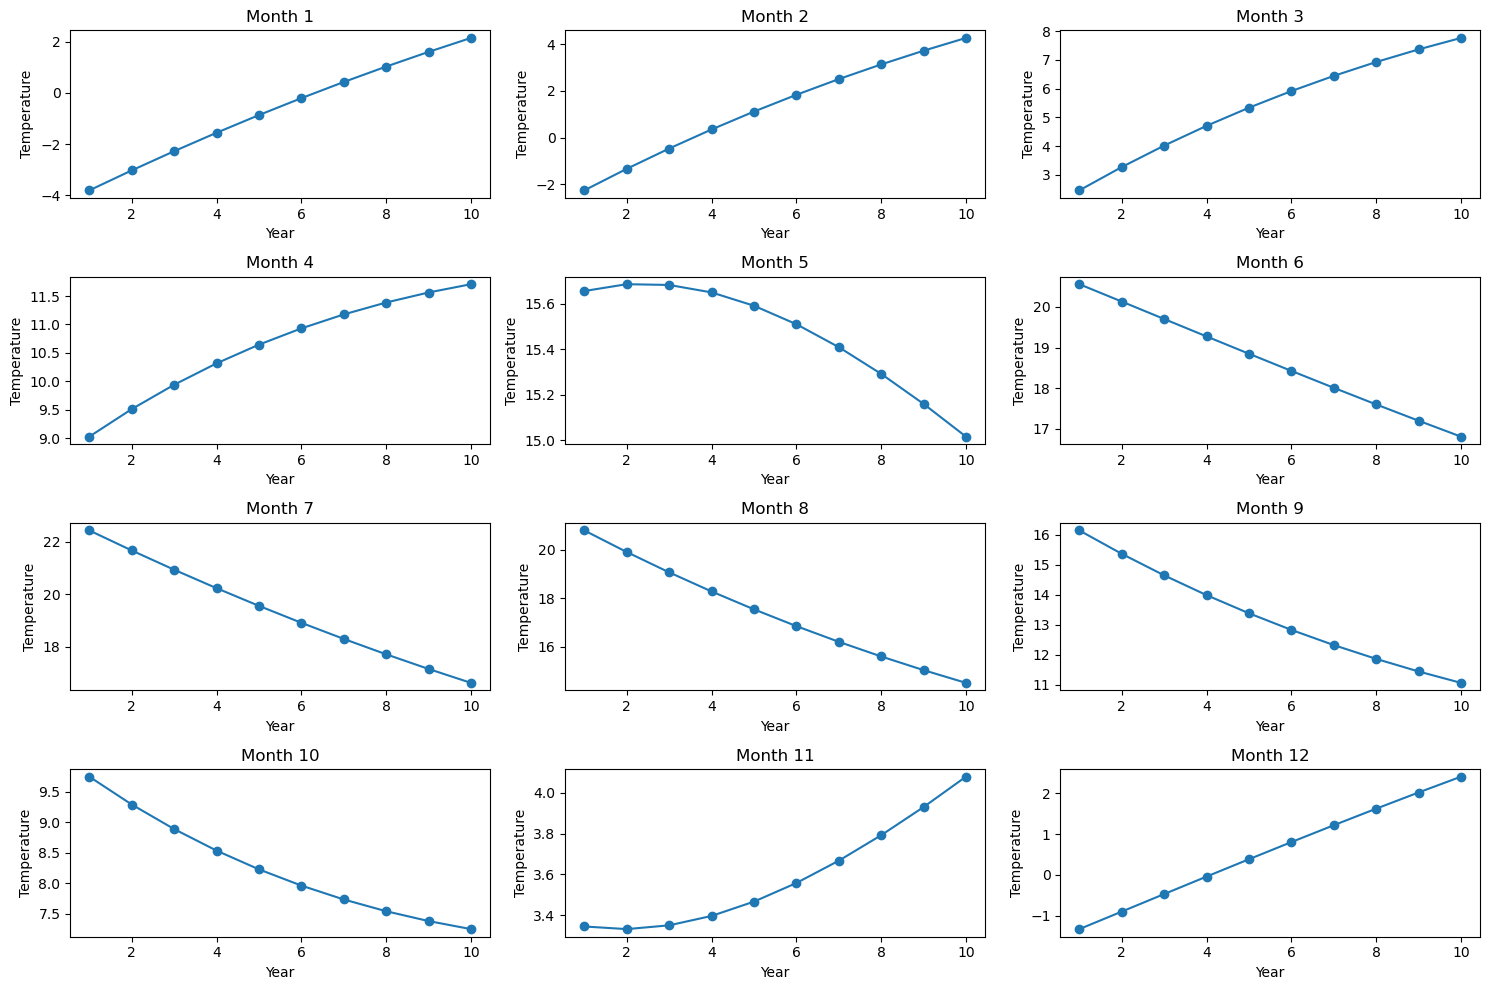

In [15]:
import matplotlib.pyplot as plt


forecast_values = list(out_of_sample_forecast)

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

monthly_change = {}

for month in range(12):
    temp = month
    for year in range(num_years):
        if month not in monthly_change:
            monthly_change[month] = [forecast_values[temp]]
        else:
            monthly_change[month].append(forecast_values[temp])
        temp += 12  


for i, (month, temps) in enumerate(monthly_change.items()):
    row = i // 3
    col = i % 3
    ax[row, col].plot(range(1, num_years + 1), temps, marker='o')
    ax[row, col].set_title(f'Month {month + 1}')  
    ax[row, col].set_xlabel('Year')
    ax[row, col].set_ylabel('Temperature')

plt.tight_layout()
plt.show()

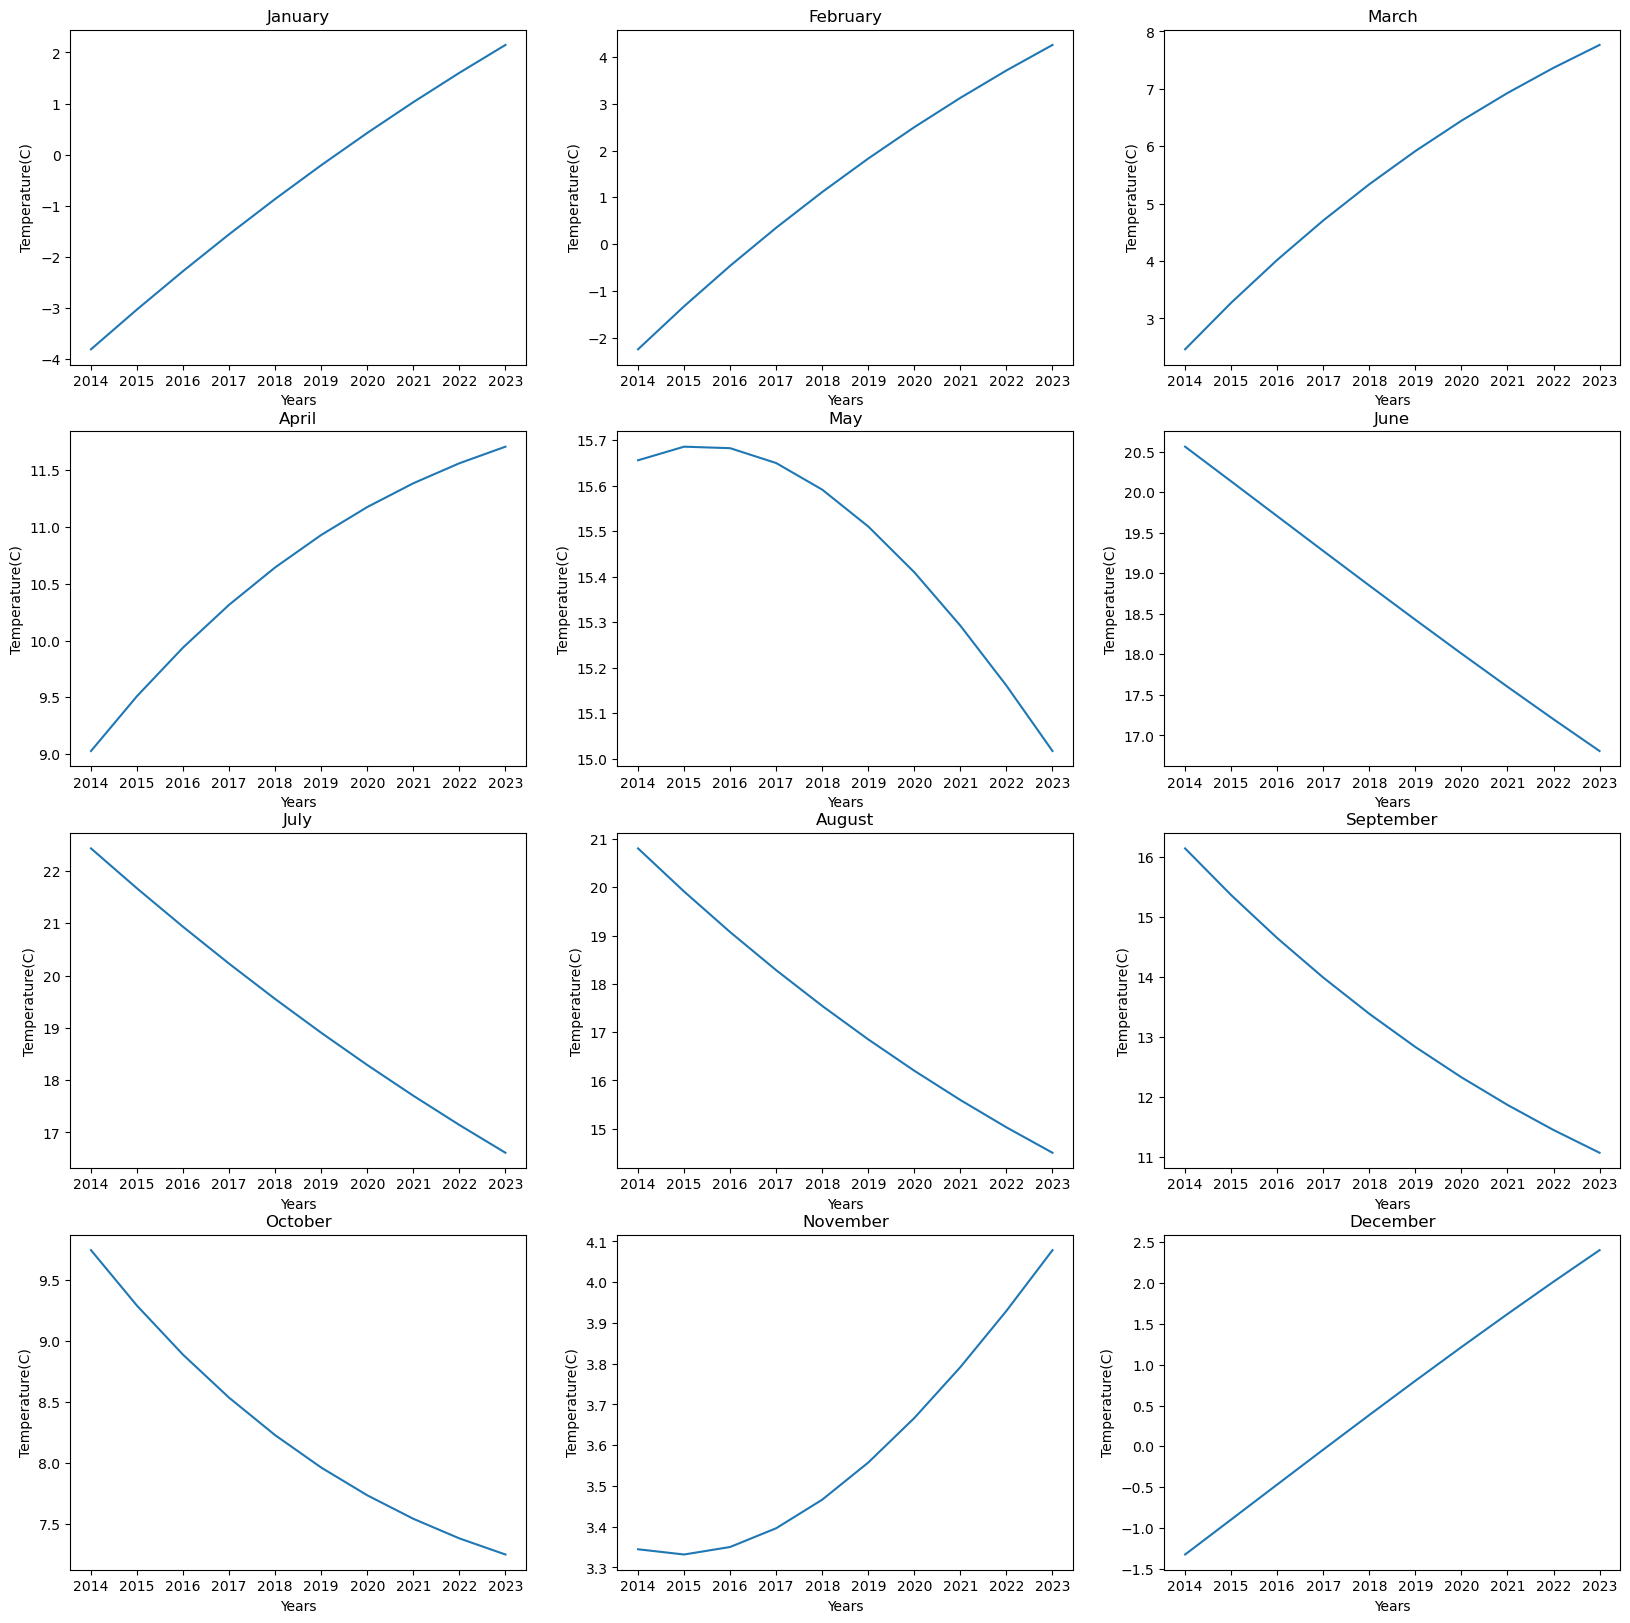

In [16]:
plt.figure(figsize=(20,20))
for pos in range(0,12):
    plt.subplot(4,3,pos+1)
    plt.plot(monthly_change[pos])
    plt.xticks(np.array(range(num_years)), [i for i in range(2014,2014+num_years)])
    plt.title(months[pos])
    plt.xlabel('Years')
    plt.ylabel('Temperature(C)')

plt.show()

In [17]:
df = pd.read_csv("Desktop/Major/GlobalLandTemperaturesByCity.csv")

df['dt'] = pd.to_datetime(df['dt'])

df.index = df['dt']
del df['dt']
df = df.drop({"AverageTemperatureUncertainty"}, 1)
df = df.dropna()


new_us_cities_df = df[df.Country=='United States'].drop('Country', 1)
new_us_cities_df['latlon'] = new_us_cities_df['Latitude'] + ', ' + new_us_cities_df['Longitude']
new_us_cities_df = new_us_cities_df.sort_values('latlon')
unique_latlon_values = set(list(new_us_cities_df.latlon))

cities = list(new_us_cities_df.City)

unique_latlon_first_cities = []

for x in unique_latlon_values:
    i = list(new_us_cities_df.latlon).index(x)
    unique_latlon_first_cities.append(cities[i])

part_2_df = df[df['City'].isin(unique_latlon_first_cities)].drop(['Country', 'Latitude', 'Longitude'], 1)
part_2_df.head()

,AverageTemperature,City
dt,,
1820-01-01,2.101,Abilene
1820-02-01,6.926,Abilene
1820-03-01,10.767,Abilene
1820-04-01,17.989,Abilene
1820-05-01,21.809,Abilene


In [18]:
df = pd.read_csv('Desktop/Major/pollution_us_2000_2016.csv')
new_df = df.drop(['Unnamed: 0','State Code', 'County Code', 'Site Num', 'Address',
       'State', 'County', 'NO2 Units', 'NO2 Mean',
       'NO2 1st Max Value', 'NO2 1st Max Hour', 'O3 Units',
       'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'SO2 Units',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour','CO Units', 'CO Mean','CO 1st Max Value', 'CO 1st Max Hour'],axis = 1)

In [19]:
no2_df = new_df.drop(['O3 AQI', 'SO2 AQI', 'CO AQI'],1)

no2_df = no2_df.sort_values('NO2 AQI', ascending = 0).drop_duplicates(subset='Date Local', keep='first')

no2_df['Date Local'] = pd.to_datetime(no2_df['Date Local'])
no2_df.index = no2_df['Date Local']
del no2_df['Date Local']

no2_df = no2_df[no2_df['City'] == 'New York']


no2_df = no2_df.resample("A").mean()
no2_df= no2_df.sort_index()
no2_df = no2_df.dropna()


so2_df = new_df.drop(['O3 AQI', 'NO2 AQI', 'CO AQI'],1)
so2_df = so2_df.sort_values('SO2 AQI',ascending = 0).drop_duplicates(subset='Date Local', keep='first')
so2_df['Date Local'] = pd.to_datetime(so2_df['Date Local'])
so2_df.index = so2_df['Date Local']
del so2_df['Date Local']
so2_df = so2_df[so2_df['City'] == 'New York']
so2_df = so2_df.resample("A").mean()
so2_df= so2_df.sort_index()
so2_df = so2_df.dropna()
so2_df.head()

co_df = new_df.drop(['SO2 AQI', 'NO2 AQI', 'O3 AQI'],1)
co_df = co_df.sort_values('CO AQI',ascending = 0).drop_duplicates(subset='Date Local', keep='first')
co_df['Date Local'] = pd.to_datetime(co_df['Date Local'])
co_df.index = co_df['Date Local']
del co_df['Date Local']
co_df = co_df[co_df['City'] == 'New York']
co_df = co_df.resample("A").mean()
co_df= co_df.sort_index()
co_df = co_df.dropna()

In [20]:
df = pd.read_csv("Desktop/Major/GlobalLandTemperaturesByCity.csv")
df = df[df['Country'] == 'United States']
df = df[df['City'] == 'New York']
df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)


df['Date Local'] = pd.to_datetime(df['dt'])

df.index = df['Date Local']
del df['dt'],df['City'],df['Country']
df.dropna()


df = df.resample("A").mean()

df = df.dropna()
df = df.sort_index()

In [21]:
j1 = pd.merge(df, no2_df, left_index = True, right_index = True, how='inner')
j2 = pd.merge(so2_df, j1, left_index = True, right_index = True, how='inner')
j3 = pd.merge(co_df, j2, left_index = True, right_index = True, how='inner')
j3.head()

,CO AQI,SO2 AQI,AverageTemperature,NO2 AQI
Date Local,,,,
2000-12-31,30.250000,62.476190,9.969083,70.000000
2001-12-31,19.000000,61.285714,10.931000,75.735294
2002-12-31,17.625000,59.342105,11.252167,71.692308
2003-12-31,19.357143,59.388889,9.836000,66.148148
2004-12-31,15.538462,53.675676,10.389500,64.921053


In [22]:
j3_norm = (j3 - j3.mean()) / (j3.max() - j3.min())
j3_norm.head()

,CO AQI,SO2 AQI,AverageTemperature,NO2 AQI
Date Local,,,,
2000-12-31,0.654585,0.357917,-0.404637,0.347543
2001-12-31,0.132401,0.329215,0.008577,0.575799
2002-12-31,0.068578,0.282354,0.146542,0.414894
2003-12-31,0.148978,0.283482,-0.461806,0.194245
2004-12-31,-0.028272,0.145735,-0.224037,0.145408


In [23]:
trace0 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['AverageTemperature'],
    mode = 'lines',
    name = 'Temperature'
)

trace1 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['CO AQI'],
    mode = 'lines',
    name = 'Carbon Monoxide'
)

trace3 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['SO2 AQI'],
    mode = 'lines',
    name = 'Sulphur Dioxide'
)

trace4 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['NO2 AQI'],
    mode = 'lines',
    name = 'Nitrogen Dioxide'
)

layout = go.Layout(
    title='Temperature and Pollution Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace3,trace4]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

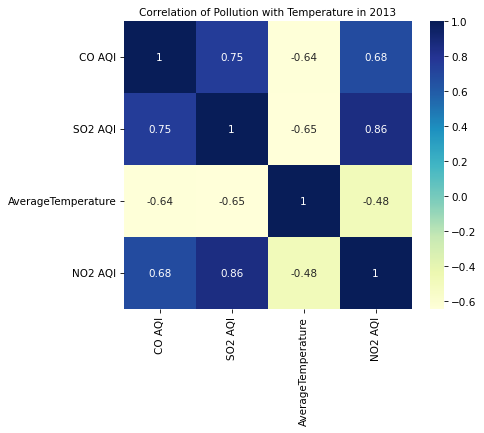

In [24]:
fig = plt.figure(dpi = 75)

ax = fig.add_axes([0.1, 0.1, 0.75, 0.8]) 
sns.heatmap(j3_norm.corr(method='pearson'), annot = True, cmap="YlGnBu")
ax.set_title("Correlation of Pollution with Temperature in 2013", fontsize=10)
plt.show()

In [25]:
df = pd.read_csv("Desktop/Major/GlobalLandTemperaturesByCity.csv")


df['dt'] = pd.to_datetime(df['dt'])

df.index = df['dt']
del df['dt']

df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude","Country"}, 1)

df = df.dropna()

df = df[df['City']=='New York']
df = df.drop({'City'},1)
df = df.resample("A").mean()

In [26]:
gg_df = pd.read_csv("Desktop/Major/greenhouse_gas_inventory_data_data.csv")

df_usa = gg_df[gg_df['country_or_area']=='United States of America'].drop('country_or_area', 1)


df_usa_co2 = df_usa[df_usa['category']=='carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_co2 = df_usa_co2.sort_values('year')
df_usa_co2.columns=['year','co2']

df_usa_methane = df_usa[df_usa['category']=='methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_methane = df_usa_methane.sort_values('year')
df_usa_methane.columns=['year','methane']

df_usa_n2o = df_usa[df_usa['category']=='nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_n2o = df_usa_n2o.sort_values('year')
df_usa_n2o.columns=['year','n2o']

df_usa_hcfc = df_usa[df_usa['category']=='hydrofluorocarbons_hfcs_emissions_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_hcfc = df_usa_hcfc.sort_values('year')
df_usa_hcfc.columns=['year','hcfc']

# Set Index
df_usa_co2.index = df_usa_co2['year']
df_usa_methane.index = df_usa_methane['year']
df_usa_n2o.index = df_usa_n2o['year']
df_usa_hcfc.index = df_usa_hcfc['year']

del df_usa_co2['year'],df_usa_methane['year'],df_usa_n2o['year'],df_usa_hcfc['year']

In [27]:
co2 = df_usa_co2['co2']
n2o = df_usa_n2o['n2o']
methane = df_usa_methane['methane']
hcfc = df_usa_hcfc['hcfc']
temp = list(df['AverageTemperature'])[-25:]

part3 = pd.DataFrame({'co2':co2,'n2o':n2o,'methane':methane,'hcfc':hcfc,'temp': temp},columns = ['co2','n2o','methane','hcfc','temp'])
part3.head()

,co2,n2o,methane,hcfc,temp
year,,,,,
1990,5.115095e+06,406228.526626,773854.896420,46288.814184,9.661333
1991,5.064880e+06,396113.656867,777034.220915,41618.413588,11.322500
1992,5.170274e+06,404052.107073,776869.789752,47427.662176,11.357250
1993,5.284759e+06,420503.190940,764089.671267,47500.262267,9.572667
1994,5.377492e+06,402478.930460,770450.426146,53246.654974,10.040917


In [28]:
part3_norm = (part3 - part3.mean()) / (part3.max() - part3.min())

In [29]:
trace0 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['temp'],
    mode = 'lines',
    name = 'Temperature'
)

trace1 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['co2'],
    mode = 'lines',
    name = 'Carbon Dioxide'
)

trace2 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['n2o'],
    mode = 'lines',
    name = 'Nitrous Oxide'
)

trace3 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['methane'],
    mode = 'lines',
    name = 'Methane'
)

trace4 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['hcfc'],
    mode = 'lines',
    name = 'Hydrofluorocarbon'
)

layout = go.Layout(
    title='Temperature and Greenhouse Gases Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace2,trace3,trace4]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

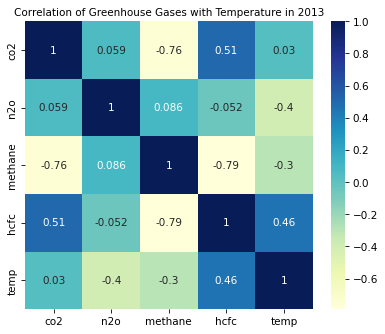

In [30]:
fig = plt.figure(dpi = 75)

ax = fig.add_axes([0.1, 0.1, 0.75, 0.8]) 
sns.heatmap(part3.corr(method='pearson'), annot = True, cmap="YlGnBu")
ax.set_title("Correlation of Greenhouse Gases with Temperature in 2013", fontsize=10)
plt.show()

In [32]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


ny_df = pd.read_csv("Desktop/Major/GlobalLandTemperaturesByCity.csv")
ny_df = ny_df[ny_df['Country'] == 'United States']
ny_df = ny_df[ny_df['City'] == 'New York']
ny_df = ny_df.drop(["AverageTemperatureUncertainty", "Latitude", "Longitude"], axis=1)


ny_df['Date Local'] = pd.to_datetime(ny_df['dt'])
ny_df.set_index('Date Local', inplace=True)
ny_df.drop(['dt', 'City', 'Country'], axis=1, inplace=True)
ny_df.dropna(inplace=True)


ny_df = ny_df.resample("A").mean()
ny_df.dropna(inplace=True)
ny_df.sort_index(inplace=True)

def check_stationarity(data):
    result = adfuller(data)
    return result[1]  # p-value

if check_stationarity(ny_df['AverageTemperature']) > 0.05:
    
    ny_df_diff = ny_df.diff().dropna()
else:
    ny_df_diff = ny_df

# fitting an ARIMA model
p_range = q_range = list(range(0, 3))  
aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(ny_df_diff, order=(p, 1, q))  
            results = model.fit()
            aic_values.append(results.aic)  
            bic_values.append(results.bic)
            pq_values.append((p, q))
        except:
            pass


if aic_values:
    best_pq = pq_values[aic_values.index(min(aic_values))]  
    print("(p,q) corresponding to lowest AIC score: ", best_pq)

    arima_model = ARIMA(ny_df, order=(best_pq[0], 1, best_pq[1])).fit()


    ny_out_of_sample_forecast = arima_model.forecast(steps=10)


    future_gg = pd.DataFrame({'Year': pd.date_range(start=ny_df.index[-1], periods=11, freq='A')[1:], 
                              'Temperature': ny_out_of_sample_forecast})

    print(future_gg)
else:
    print("No valid models were found. Please check your data and model parameters.")


(p,q) corresponding to lowest AIC score:  (2, 2)
          Year  Temperature
266 2014-12-31    11.053082
267 2015-12-31    11.602293
268 2016-12-31    11.516462
269 2017-12-31    11.373873
270 2018-12-31    11.551583
271 2019-12-31    11.433751
272 2020-12-31    11.477339
273 2021-12-31    11.482851
274 2022-12-31    11.459256
275 2023-12-31    11.480475


In [33]:
part3_norm = future_gg[['Temperature']].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))


part3_norm.head()

,Temperature
266,-0.710136
267,0.289864
268,0.133583
269,-0.126042
270,0.197532
